In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from tqdm import tqdm
import lightgbm as lgbm
import re
from sklearn.ensemble import RandomForestRegressor 

import os
import json
%matplotlib inline

import keras
import tensorflow as tf

from keras.layers import Dense, Activation, Conv2D,Conv1D, Flatten,MaxPooling2D,BatchNormalization,Lambda, AveragePooling2D, MaxPooling1D
import keras.backend as K
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback, EarlyStopping
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential, load_model

In [ ]:
print("keras_version : " + str(keras.__version__))
print("numpy_version : " + str(np.__version__))
print("pandas_version : " + str(pd.__version__))
print("tensorflow_version :" + str(tf.__version__))

keras_version : 2.4.3
numpy_version : 1.18.5
pandas_version : 1.1.4
tensorflow_version :2.3.0


In [ ]:
train = pd.read_csv("/content/drive/My Drive/Dacon_튜터/train_features.csv", index_col=0)
test = pd.read_csv("/content/drive/My Drive/Dacon_튜터/test_features.csv", index_col=0)
y_train = pd.read_csv("/content/drive/My Drive/Dacon_튜터/train_target.csv", index_col=0)
y_test = pd.read_csv("/content/drive/My Drive/Dacon_튜터/sample_submission.csv", index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
def transform1(train, n1, n2):
    train_time = train.copy()
    train_time['S1'] = [1 if i != 0 else 0 for i in train['S1']]
    train_time['S2'] = [1 if i != 0 else 0 for i in train['S2']]
    train_time['S3'] = [1 if i != 0 else 0 for i in train['S3']]
    train_time['S4'] = [1 if i != 0 else 0 for i in train['S4']]
    train_time.drop(['Time'], axis=1, inplace=True)
    
    train_time = train_time.sum(axis=1)
    train_time = train_time.transform(lambda x: (x-x.mean())/(x.std()))
    train_time = np.array(train_time).reshape(n1, n2, 1, 1)
    
    return train_time

In [ ]:
train = train.transform(lambda x: (x-x.mean())/(x.std()))
test = test.transform(lambda x: (x-x.mean())/(x.std()))

###

X_data = train.iloc[:,:]
X_data = np.array(X_data).reshape((2800,375,5))

X_data_test = test.iloc[:,:]
X_data_test = np.array(X_data_test).reshape((700,375,5))

Y_data = np.array(y_train.copy())

In [ ]:
X_data_Case4 = X_data.copy()
X_data_test_Case4 = X_data_test.copy()
Y_data_Case4 = Y_data.copy()

# Conv2D(3,1)짜리와는 다르게 sample하나의 shape이 2차원으로 들어가야 합니다\
- 성능(0.04)

In [ ]:
X_data.shape

(2800, 375, 5)

모델링

In [ ]:
import math
from keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        #if self.verbose &gt; 0:
        #    print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
        #          'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
import numpy as np

def kaeri_metric(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''
    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)


### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)


def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    
    
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

In [ ]:
weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])

def my_loss(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult))


def my_loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04

def my_loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)

In [ ]:
def plot_error(type_id,pred,true):
    print(pred.shape)

    if type_id == 0:
        _name = 'x_pos'
    elif type_id == 1:
        _name = 'y_pos'
    elif type_id == 2:
        _name = 'mass'
    elif type_id == 3:
        _name = 'velocity'
    elif type_id == 4:
        _name = "distance"
    else:
        _name = 'error'

    x_coord = np.arange(1,pred.shape[0]+1,1)
    if type_id < 2:
        Err_m = (pred[:,type_id] - true[:,type_id])
    elif type_id < 4:
        Err_m = ((pred[:,type_id] - true[:,type_id])/true[:,type_id])*100
    else:
        Err_m = ((pred[:,0]-true[:,0])**2+(pred[:,1]-true[:,1])**2)**0.5


    fig = plt.figure(figsize=(8,6))
    # plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.size"]=15
    plt.scatter(x_coord, Err_m, marker='o')
    plt.title("%s Prediction for Training Data" % _name, size=20)
    plt.xlabel("Data ID", labelpad=10, size=20)
    plt.ylabel("Prediction Error of %s," % _name, labelpad=10, size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(-100., 100.)
    plt.xlim(0, pred.shape[0]+1)

    plt.show()
    
    print(np.std(Err_m))
    print(np.max(Err_m))
    print(np.min(Err_m))
    return Err_m

In [ ]:
def set_model(train_target, n_sam,n_col, regularizer_True):  # 0:x,y, 1:m, 2:v
    
    activation = 'elu'
    padding = 'same'
    model = Sequential()
    nf = 16
    fs = 3
    pool_size = 2

    model.add(Conv1D(nf,fs, padding=padding, activation=activation,input_shape=(n_sam,n_col)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(nf*2,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(nf*4,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(nf*8,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(nf*16,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Conv1D(nf*32,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))
    
    model.add(Flatten())
    model.add(Dense(128, activation ='elu'))
    model.add(Dense(64, activation ='elu'))
    model.add(Dense(32, activation ='elu'))
    model.add(Dense(16, activation ='elu'))
    
    if regularizer_True:
        model.add(Dense(4, kernel_regularizer=l1_l2(l1=0.001)))
    else:
        model.add(Dense(4))
    

    optimizer = keras.optimizers.Adam()
    #optimizer = keras.optimizers.RMSprop()
    
    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1,
                  optimizer=optimizer,
                 )
    else:
        model.compile(loss=my_loss_E2,
                  optimizer=optimizer,
                 )
       
    model.summary()

    return model

In [ ]:
def train_CNN(model,X,Y,X_val,Y_val, save_point, enum, train_target, scheduler_True):
    
    from numpy.random import seed
    seed(777)
    
    MODEL_SAVE_FOLDER_PATH = './model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
    best_save = ModelCheckpoint('best_m_' + str(save_point) + "_" + str(enum) + "_" + str(train_target) + '.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    cosine_scheduler = CosineAnnealingScheduler(T_max=100, eta_max=6e-3, eta_min=1e-6)

    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=patience)
    
    my_seed = 777
    np.random.seed(my_seed)
    if scheduler_True:
        history = model.fit(X, Y,
                      epochs=10000,
                      batch_size=128,
                      shuffle=True,
                      validation_data=(X_val, Y_val),
                      verbose = 2,
                      callbacks=[best_save, early_stop,cosine_scheduler],
                      )
    else:
        history = model.fit(X, Y,
                      epochs=10000,
                      batch_size=128,
                      shuffle=True,
                      validation_data=(X_val, Y_val),
                      verbose = 2,
                      callbacks=[best_save, early_stop],
                      )
    

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()    
    
    return model

In [ ]:
def load_best_model(train_target, save_point, enum):

    if train_target == 0:
        model = load_model('best_m_' + str(save_point) + "_" + str(enum) + "_" + str(train_target) + '.hdf5' , custom_objects={'my_loss_E1': my_loss, })
    else:
        model = load_model('best_m_' + str(save_point) + "_" + str(enum) + "_" + str(train_target) + '.hdf5' , custom_objects={'my_loss_E2': my_loss, })

    score = model.evaluate(X_data, Y_data, verbose=0)
    print('loss:', score)

    pred = model.predict(X_data)

    i=0

    print('정답(original):', Y_data[i])
    print('예측값(original):', pred[i])

    print(E1(pred, Y_data))
    print(E2(pred, Y_data))
    #print(E2M(pred, Y_data))
    #print(E2V(pred, Y_data))    
    
    if train_target ==0:
        plot_error(4,pred,Y_data)
    elif train_target ==1:
        plot_error(2,pred,Y_data)
    elif train_target ==2:
        plot_error(3,pred,Y_data)    
    
    return model

In [ ]:
lr = 3e-4
lr_d = 0.0
patience = 30
dr_rate = 0

def run_model(X_data, X_data_test, Y_data, save_point,scheduler_True,regularizer_True):
    submit = pd.read_csv("/content/drive/My Drive/Dacon_튜터/sample_submission.csv", index_col=0)
    submit.iloc[:,:] = 0

    lr = 3e-4
    lr_d = 0.0
    patience = 30
    dr_rate = 0
    
    n_col = X_data.shape[2]
    n_sam = X_data.shape[1]
    
    for enum, (train_index,valid_index) in enumerate(kf.split(X_data)):
        X_train = X_data[train_index]
        Y_train = Y_data[train_index]
    
        X_val = X_data[valid_index]
        Y_val = Y_data[valid_index]
    
    
        for train_target in range(3):
            model = set_model(train_target, n_sam,n_col, regularizer_True)
        
            train_CNN(model,X_train, Y_train, X_val, Y_val, save_point, enum, train_target,scheduler_True)    
            best_model = load_best_model(train_target, save_point, enum)

   
            pred_data_test = best_model.predict(X_data_test)
            pred_data_valid = best_model.predict(X_val)
    
            if train_target == 0: # x,y 학습
                submit.iloc[:,0] += pred_data_test[:,0]/5
                submit.iloc[:,1] += pred_data_test[:,1]/5
                
            elif train_target == 1: # m 학습
                submit.iloc[:,2] += pred_data_test[:,2]/5
        
            elif train_target == 2: # v 학습
                submit.iloc[:,3] += pred_data_test[:,3]/5    
    
    return submit

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
X_data.shape

(2800, 375, 5)

In [ ]:
print("Case4 nrow : " + str(X_data_Case4.shape[1]) + " / Case4 ncol : " + str(X_data_Case4.shape[2]))
print("Case4 nrow : " + str(X_data_test_Case4.shape[1]) + " / Case4 ncol : " + str(X_data_test_Case4.shape[2]))

Case4 nrow : 375 / Case4 ncol : 5
Case4 nrow : 375 / Case4 ncol : 5


In [ ]:
X_data_Case4.shape

(2800, 375, 5)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_89 (Batc (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 187, 16)           0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_90 (Batc (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 93, 32)            0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 93, 64)          

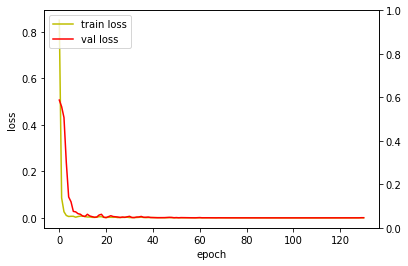

loss: 49853255680.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [  -1.23916  -401.8933    101.081985  208.49535 ]
0.0003468999514434316
172636.4165726291
(2800, 4)


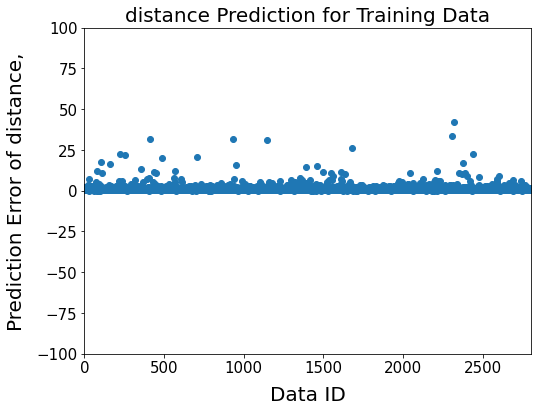

2.2287150855648328
42.32455766844281
0.027463192284209646
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_97 (Conv1D)           (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_95 (Batc (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 187, 16)           0         
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_96 (Batc (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 93, 32)            0         
_____________________________________________________________

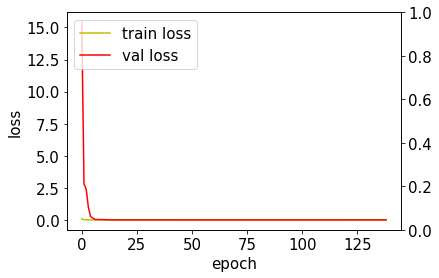

loss: 124809501474816.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 20.934856   9.543795  49.776787 -17.548151]
6.893931504942941
176.46873923134206
(2800, 4)


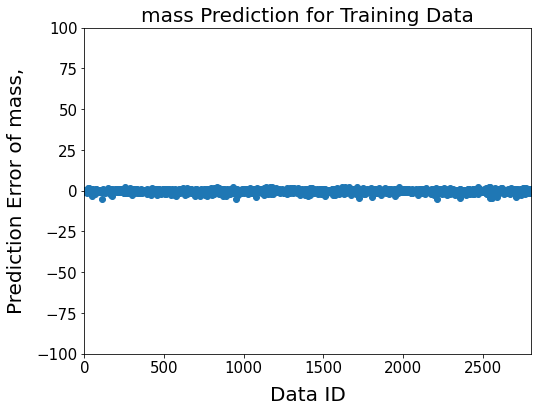

0.8277342862221337
2.5535481770833335
-5.13629150390625
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_103 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_101 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_102 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

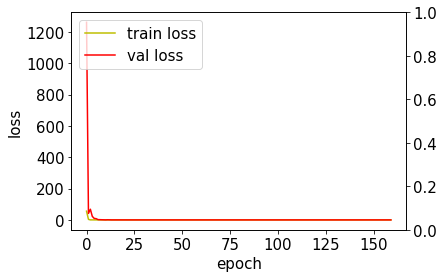

loss: 12942334492672.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ -2.6665568  -16.374271    -7.471691     0.37070298]
6.679758059432557
14180.234491710862
(2800, 4)


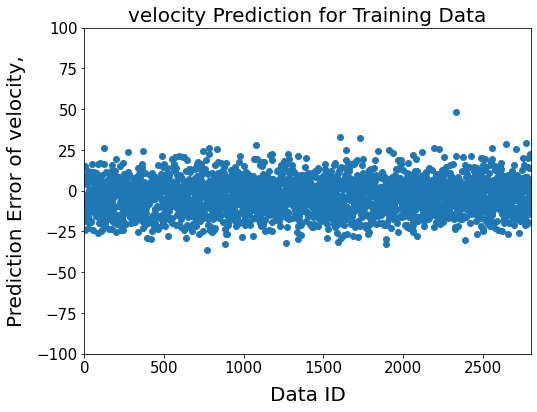

10.219076975493342
48.03412556648254
-36.45318597555161
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_109 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_107 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_108 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

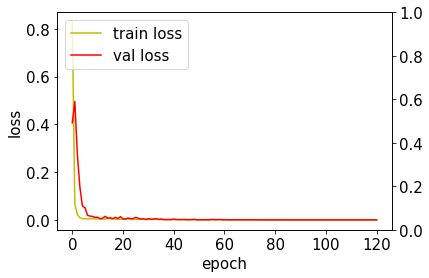

loss: 50098974720.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 1.4832622e-01 -4.0131067e+02 -5.2176605e+01 -1.2910315e+01]
0.0002723406763589632
2362616.1127315676
(2800, 4)


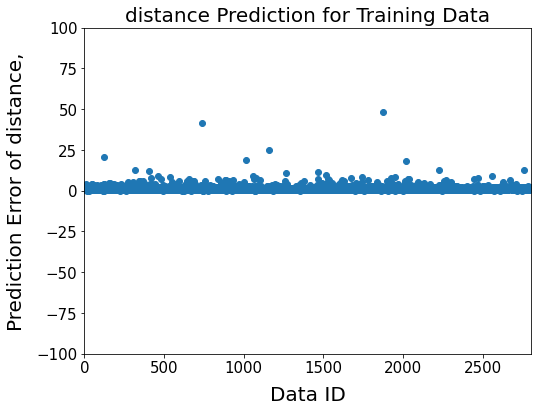

1.843890874836197
48.3362840963467
0.008037084629257134
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_115 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_113 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_114 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

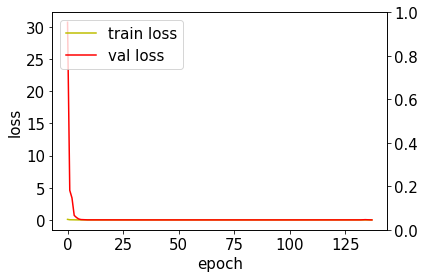

loss: 12175965945856.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [-3.4998426 -1.5635518 51.266598  -7.702305 ]
6.679668542403705
1.397845688673259
(2800, 4)


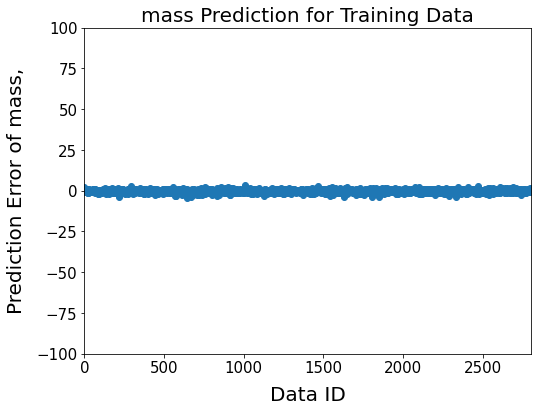

0.8113021186076854
3.3260323660714284
-4.549612862723214
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_121 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_119 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_120 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 93, 32)            0         
______________________________________________________________

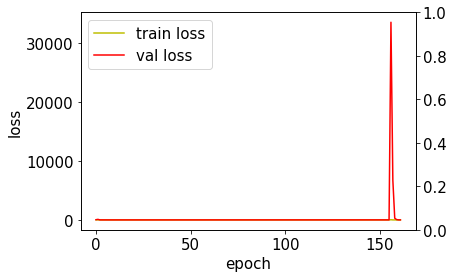

loss: 204616368128.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 0.04536158  1.6639795  -2.362551    0.42265707]
6.650668627390175
77705.96460676347
(2800, 4)


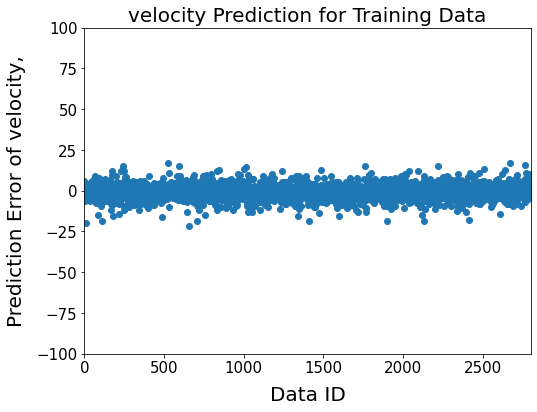

4.123454791220828
17.237603664398193
-21.63689136505127
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_127 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_125 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_126 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

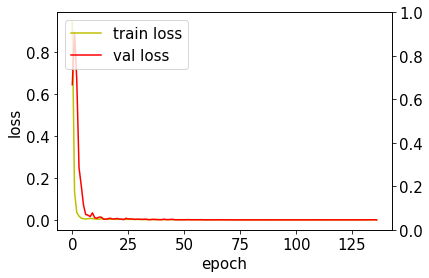

loss: 142288175104.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 3.3183765e-01 -3.9894498e+02 -5.8580978e+01  3.5535071e+02]
0.0002138346158773595
25616.597424790758
(2800, 4)


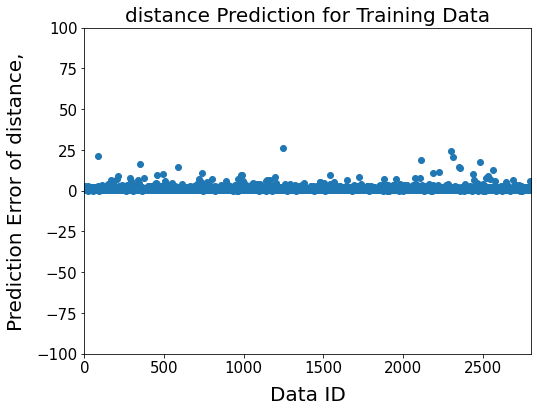

1.5751905959536516
26.261805553608053
0.004941680810108284
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_131 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_132 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 93, 32)            0         
____________________________________________________________

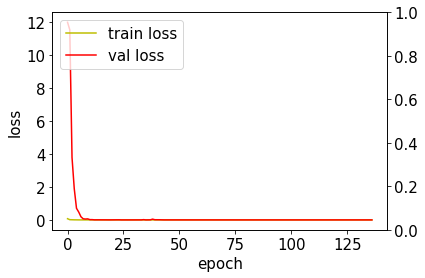

loss: 29718246064128.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [-6.514864 14.120421 50.047516 15.664848]
6.713784330173071
0.9497404610438003
(2800, 4)


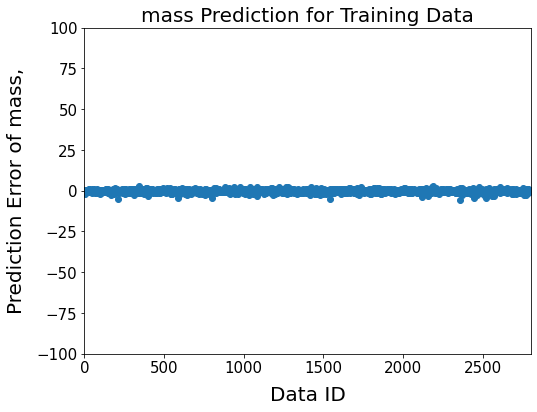

0.7623874697610323
2.79718017578125
-5.551670619419643
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_139 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_137 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_138 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 93, 32)            0         
________________________________________________________________

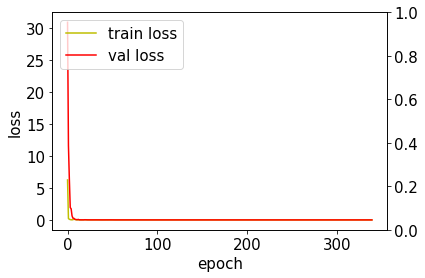

loss: 4388066951168.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [  5.071713  -10.590677   -4.552564    0.4065527]
6.649243631680983
1259.1689362159161
(2800, 4)


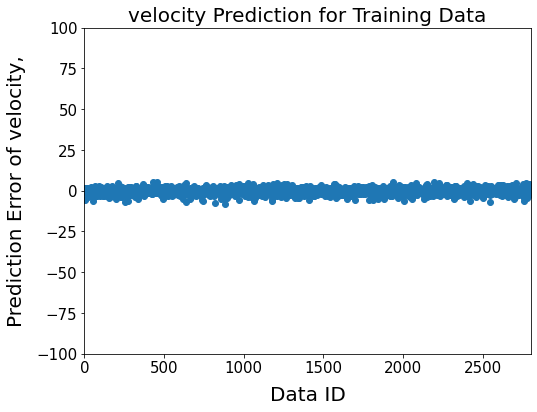

1.5748145275481678
5.404324829578394
-8.018611371517187
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_145 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_143 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_146 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_144 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

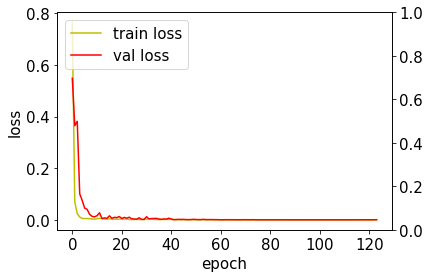

loss: 190411620352.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [   1.1064644 -404.12772    100.20064   -204.46309  ]
0.0005352732576386659
2098549.340558218
(2800, 4)


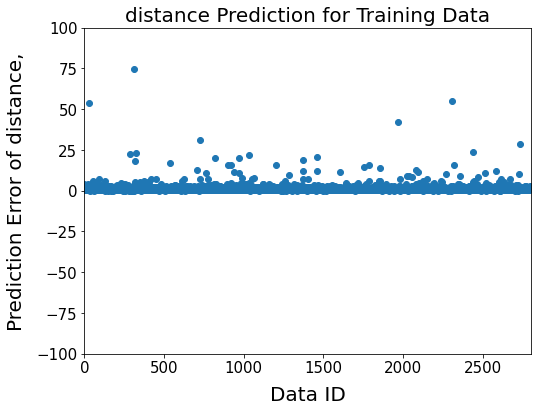

2.9000190525082337
74.53211683121239
0.01856472346286102
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_151 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_149 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_150 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 93, 32)            0         
______________________________________________________________

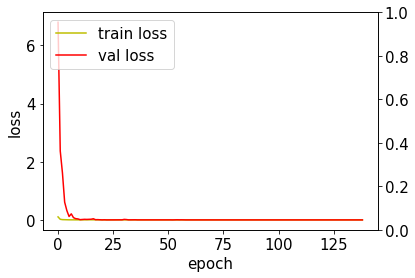

loss: 593110287515648.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [66.4859    -4.57186   48.89065   -4.9041758]
7.833921618014498
1.196490902670485
(2800, 4)


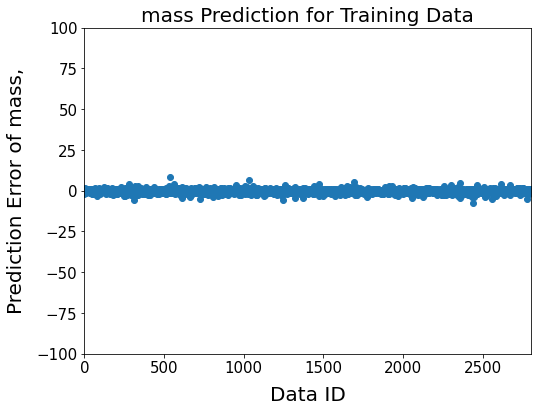

1.0388605105786366
8.624298095703125
-7.471923828125
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_157 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_155 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_156 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 93, 32)            0         
_________________________________________________________________


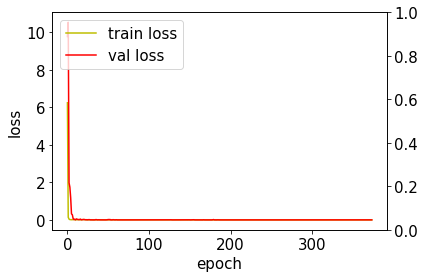

loss: 2892514197504.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 3.859882   -2.6992872   1.6244116   0.40916413]
6.652637095666809
4119.692276091002
(2800, 4)


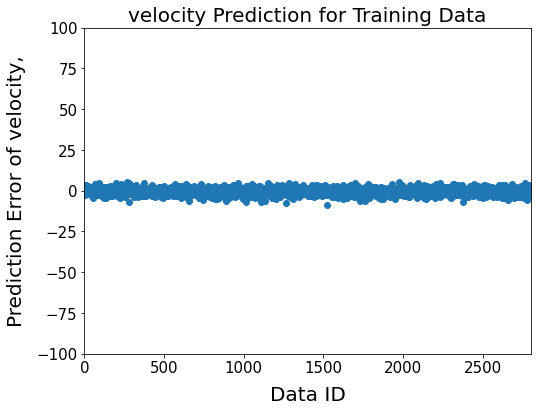

1.6672816331512612
5.223111808300013
-8.606743812561035
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_163 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_161 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_162 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

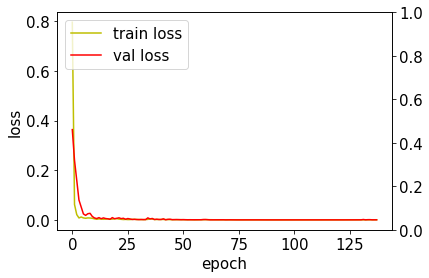

loss: 70826631168.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [   0.68090236 -401.57892    -119.024574   -360.93625   ]
0.0002694245763654711
1523.2919919252902
(2800, 4)


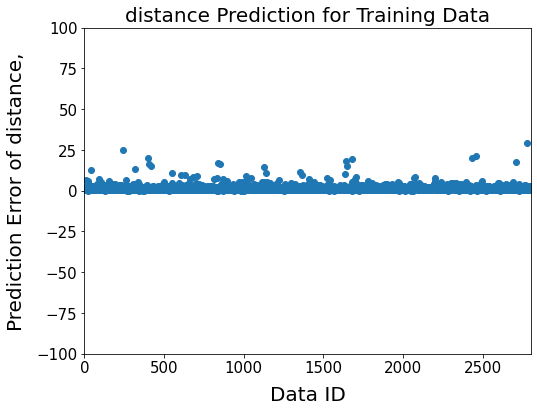

1.7450109043976472
29.05374860567174
0.00950099807460003
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_169 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_167 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_168 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 93, 32)            0         
______________________________________________________________

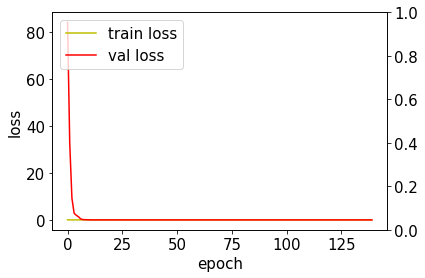

loss: 286699670208512.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [-30.510553 -26.632221  50.11567  -25.17205 ]
7.17371932396772
1.0770727918989318
(2800, 4)


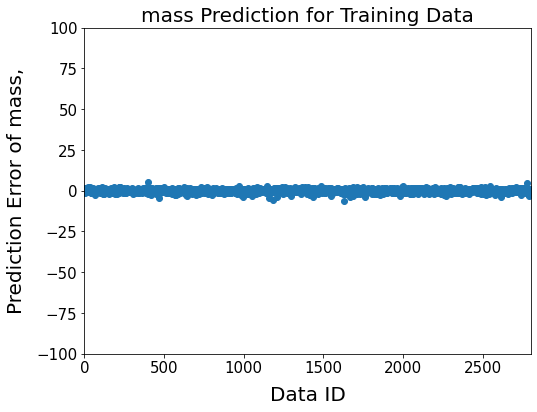

0.9176475788459678
5.362139020647321
-6.461085728236607
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_175 (Conv1D)          (None, 375, 16)           256       
_________________________________________________________________
batch_normalization_173 (Bat (None, 375, 16)           64        
_________________________________________________________________
max_pooling1d_85 (MaxPooling (None, 187, 16)           0         
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 187, 32)           1568      
_________________________________________________________________
batch_normalization_174 (Bat (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 93, 32)            0         
_______________________________________________________________

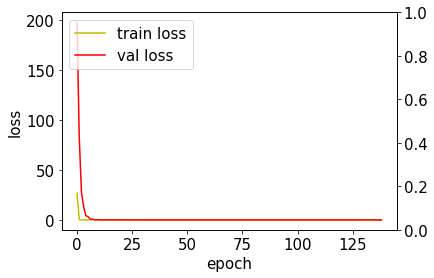

loss: 8973355843584.0
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [-13.445421     8.5577755    6.0549297    0.39663225]
6.6711539561034146
33114.776911346
(2800, 4)


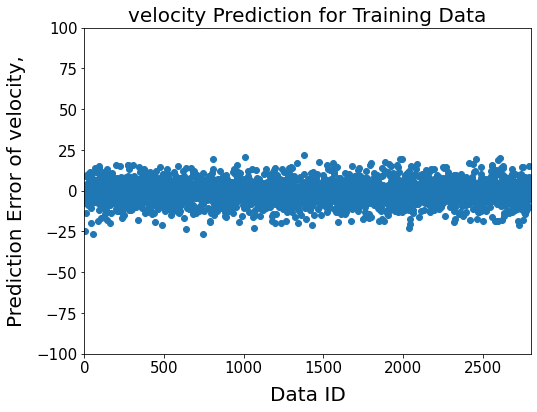

6.607146833184066
21.64100011189779
-26.801219582557685


In [ ]:
submit = run_model(X_data,X_data_test, Y_data, 1,True,False)

In [ ]:
from google.colab import files
submit.to_csv("submit_Conv1D.csv")
files.download("submit_Conv1D.csv") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>